In [1]:
%matplotlib notebook
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib as mpl
import sys
sys.path.append(r'C:\Users\shiwei\Anaconda3\Scripts\scanpy')
import scanpy as sc
import datetime
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
#results_file = r'./write/20181213.h5ad'

results_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\result.h5ad'

sc.settings.set_figure_params(dpi=150, transparent=False)  # low dpi (dots per inch) yields small inline figures

#sc.settings.figdir = '/n/home04/mengzhang/home/M1_clustering/0408/'

sc.settings.figdir = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer'

today = datetime.date.today()

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                 8.0.1
backcall            0.2.0
bottleneck          1.3.2
cffi                1.14.3
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2.30.0
dateutil            2.8.1
decorator           4.4.2
h5py                2.10.0
igraph              0.9.8
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi 

In [3]:
sc.settings.set_figure_params(dpi=150, transparent=False)

In [6]:
import mnnpy


In [7]:
from sklearn import metrics
from sklearn import preprocessing
import scipy.io as sio
from sklearn import neighbors
from sklearn.neural_network import MLPClassifier
import mnnpy
from random import choice
from sklearn.preprocessing import StandardScaler

In [8]:
dataDir = r'L:\Shiwei\Analysis\20211230MO4_nonclear'

In [9]:
MO4genes=pd.read_csv(dataDir+'MO4/MO4_genes.txt',header=None, index_col=0)
#seq_genes_new=['Vip','Sst','Calb1','Rab3b','Gad2','Slc17a7','Tac2','Penk','Lamp5','Cnr1','Gad1','Pvalb']
#allgenes=MO4genes.iloc[:-10,:].index.values.tolist()+seq_genes_new

allgenes=MO4genes.iloc[:-10,:].index.values.tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'L:\\Shiwei\\Analysis\\20211230MO4_nonclearMO4/MO4_genes.txt'

In [15]:
seqData_raw=sc.read(dataDir+'../10xMOp/sn_Broad/counts_MO4.h5ad', cache = True)





AnnData object with n_obs × n_vars = 38874 × 242
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y'

In [8]:
merfish_raw=sc.read(dataDir+'M1_final/merfish_raw.h5ad', cache = True)

In [9]:
merfish_label = pd.read_csv(dataDir+'M1_final/merfish_labels_0225.csv', index_col=0)

In [10]:
Jointcluster=pd.read_csv(baseDir+"../10xMOp/sn_Broad/Joint_10xNuclei_Broad_clusterMembership_final.csv", index_col=0)

In [11]:
Jointcluster_neuron=Jointcluster[(Jointcluster.label < 91)]
Jointcluster_glia=Jointcluster[(Jointcluster.label >=89)]
Jointcluster_in=Jointcluster[(Jointcluster.label >= 89)|(Jointcluster.label < 58)]
Jointcluster_ex=Jointcluster[(Jointcluster.label >= 58)&(Jointcluster.label < 89)]

In [12]:
seqData=seqData_raw[:,allgenes]

In [602]:
labels = merfish_label.loc[merfish_label['label']!='-1']

In [949]:
seqData = pd.DataFrame(seqData.X, index = seqData.obs.index, columns = seqData.var.index)
merData = pd.DataFrame(merfish_raw.X, index = merfish_raw.obs.index, columns = merfish_raw.var.index)

In [950]:
seqCluster=seqData.merge(Jointcluster, how='inner', left_index=True, right_index=True)
seqCluster.shape

(159738, 255)

In [960]:
merCluster=merData.merge(labels, how='inner', left_index=True, right_index=True)
merCluster.shape

(280973, 255)

In [961]:
seqGroupedDataZ = pd.DataFrame(preprocessing.scale(seqCluster.iloc[:,:-1]),index = seqCluster.iloc[:,:-1].index, columns = seqCluster.iloc[:,:-1].columns)
merGroupedDataZ = pd.DataFrame(preprocessing.scale(merCluster.iloc[:,:-1]),index = merCluster.iloc[:,:-1].index, columns = merCluster.iloc[:,:-1].columns)

seqGroupedDataZ['labels'] = seqCluster.iloc[:,-1]
merGroupedDataZ['labels'] = merCluster.iloc[:,-1]

/n/home04/mengzhang/.conda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype float32 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/n/home04/mengzhang/.conda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype float32 were all converted to float64 by the scale function.
  


In [404]:
#train on seq data
scaler = StandardScaler().fit(seqGroupedDataZ.iloc[:,:-1])
Standard_X = scaler.transform(seqGroupedDataZ.iloc[:,:-1])
Standard_X_test = scaler.transform(merGroupedDataZ.iloc[:,:-1])

netclassifier = MLPClassifier(max_iter = 500)
netclassifier.fit(Standard_X,seqGroupedDataZ['labels'])

predictions = pd.DataFrame(netclassifier.predict(Standard_X_test))
predictions = pd.concat([predictions,merGroupedDataZ.loc[:,['labels']].reset_index(drop=True)],axis = 1)
predictions.columns = ['prediction','label']

In [962]:
#train on merfish data
scaler = StandardScaler().fit(merGroupedDataZ.iloc[:,:-1])
Standard_X = scaler.transform(merGroupedDataZ.iloc[:,:-1])
Standard_X_test = scaler.transform(seqGroupedDataZ.iloc[:,:-1])

netclassifier_mer = MLPClassifier(max_iter = 500)
netclassifier_mer.fit(Standard_X,merGroupedDataZ['labels'])

predictions = pd.DataFrame(netclassifier_mer.predict(Standard_X_test))
predictions = pd.concat([predictions,seqGroupedDataZ.loc[:,['labels']].reset_index(drop=True)],axis = 1)
predictions.columns = ['prediction','label']

In [963]:
predictionMatrix = predictions.groupby(['label','prediction']).size().reset_index().pivot(index = 'label',columns = 'prediction',values = 0).fillna(0)
predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)

In [13]:
# %load sorting.py

In [14]:
fractions_sorted, rows, columns = runPermutation(fractions,'Columns')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/n/home04/mengzhang/.conda/envs/scanpy/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-5b5b74b90dc7>", line 1, in <module>
    fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
NameError: name 'runPermutation' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/n/home04/mengzhang/.conda/envs/scanpy/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2016, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/n/home04/mengzhang/.conda/envs/scanpy/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    retur

NameError: name 'runPermutation' is not defined

In [705]:
len(fractions_sorted.columns)

95

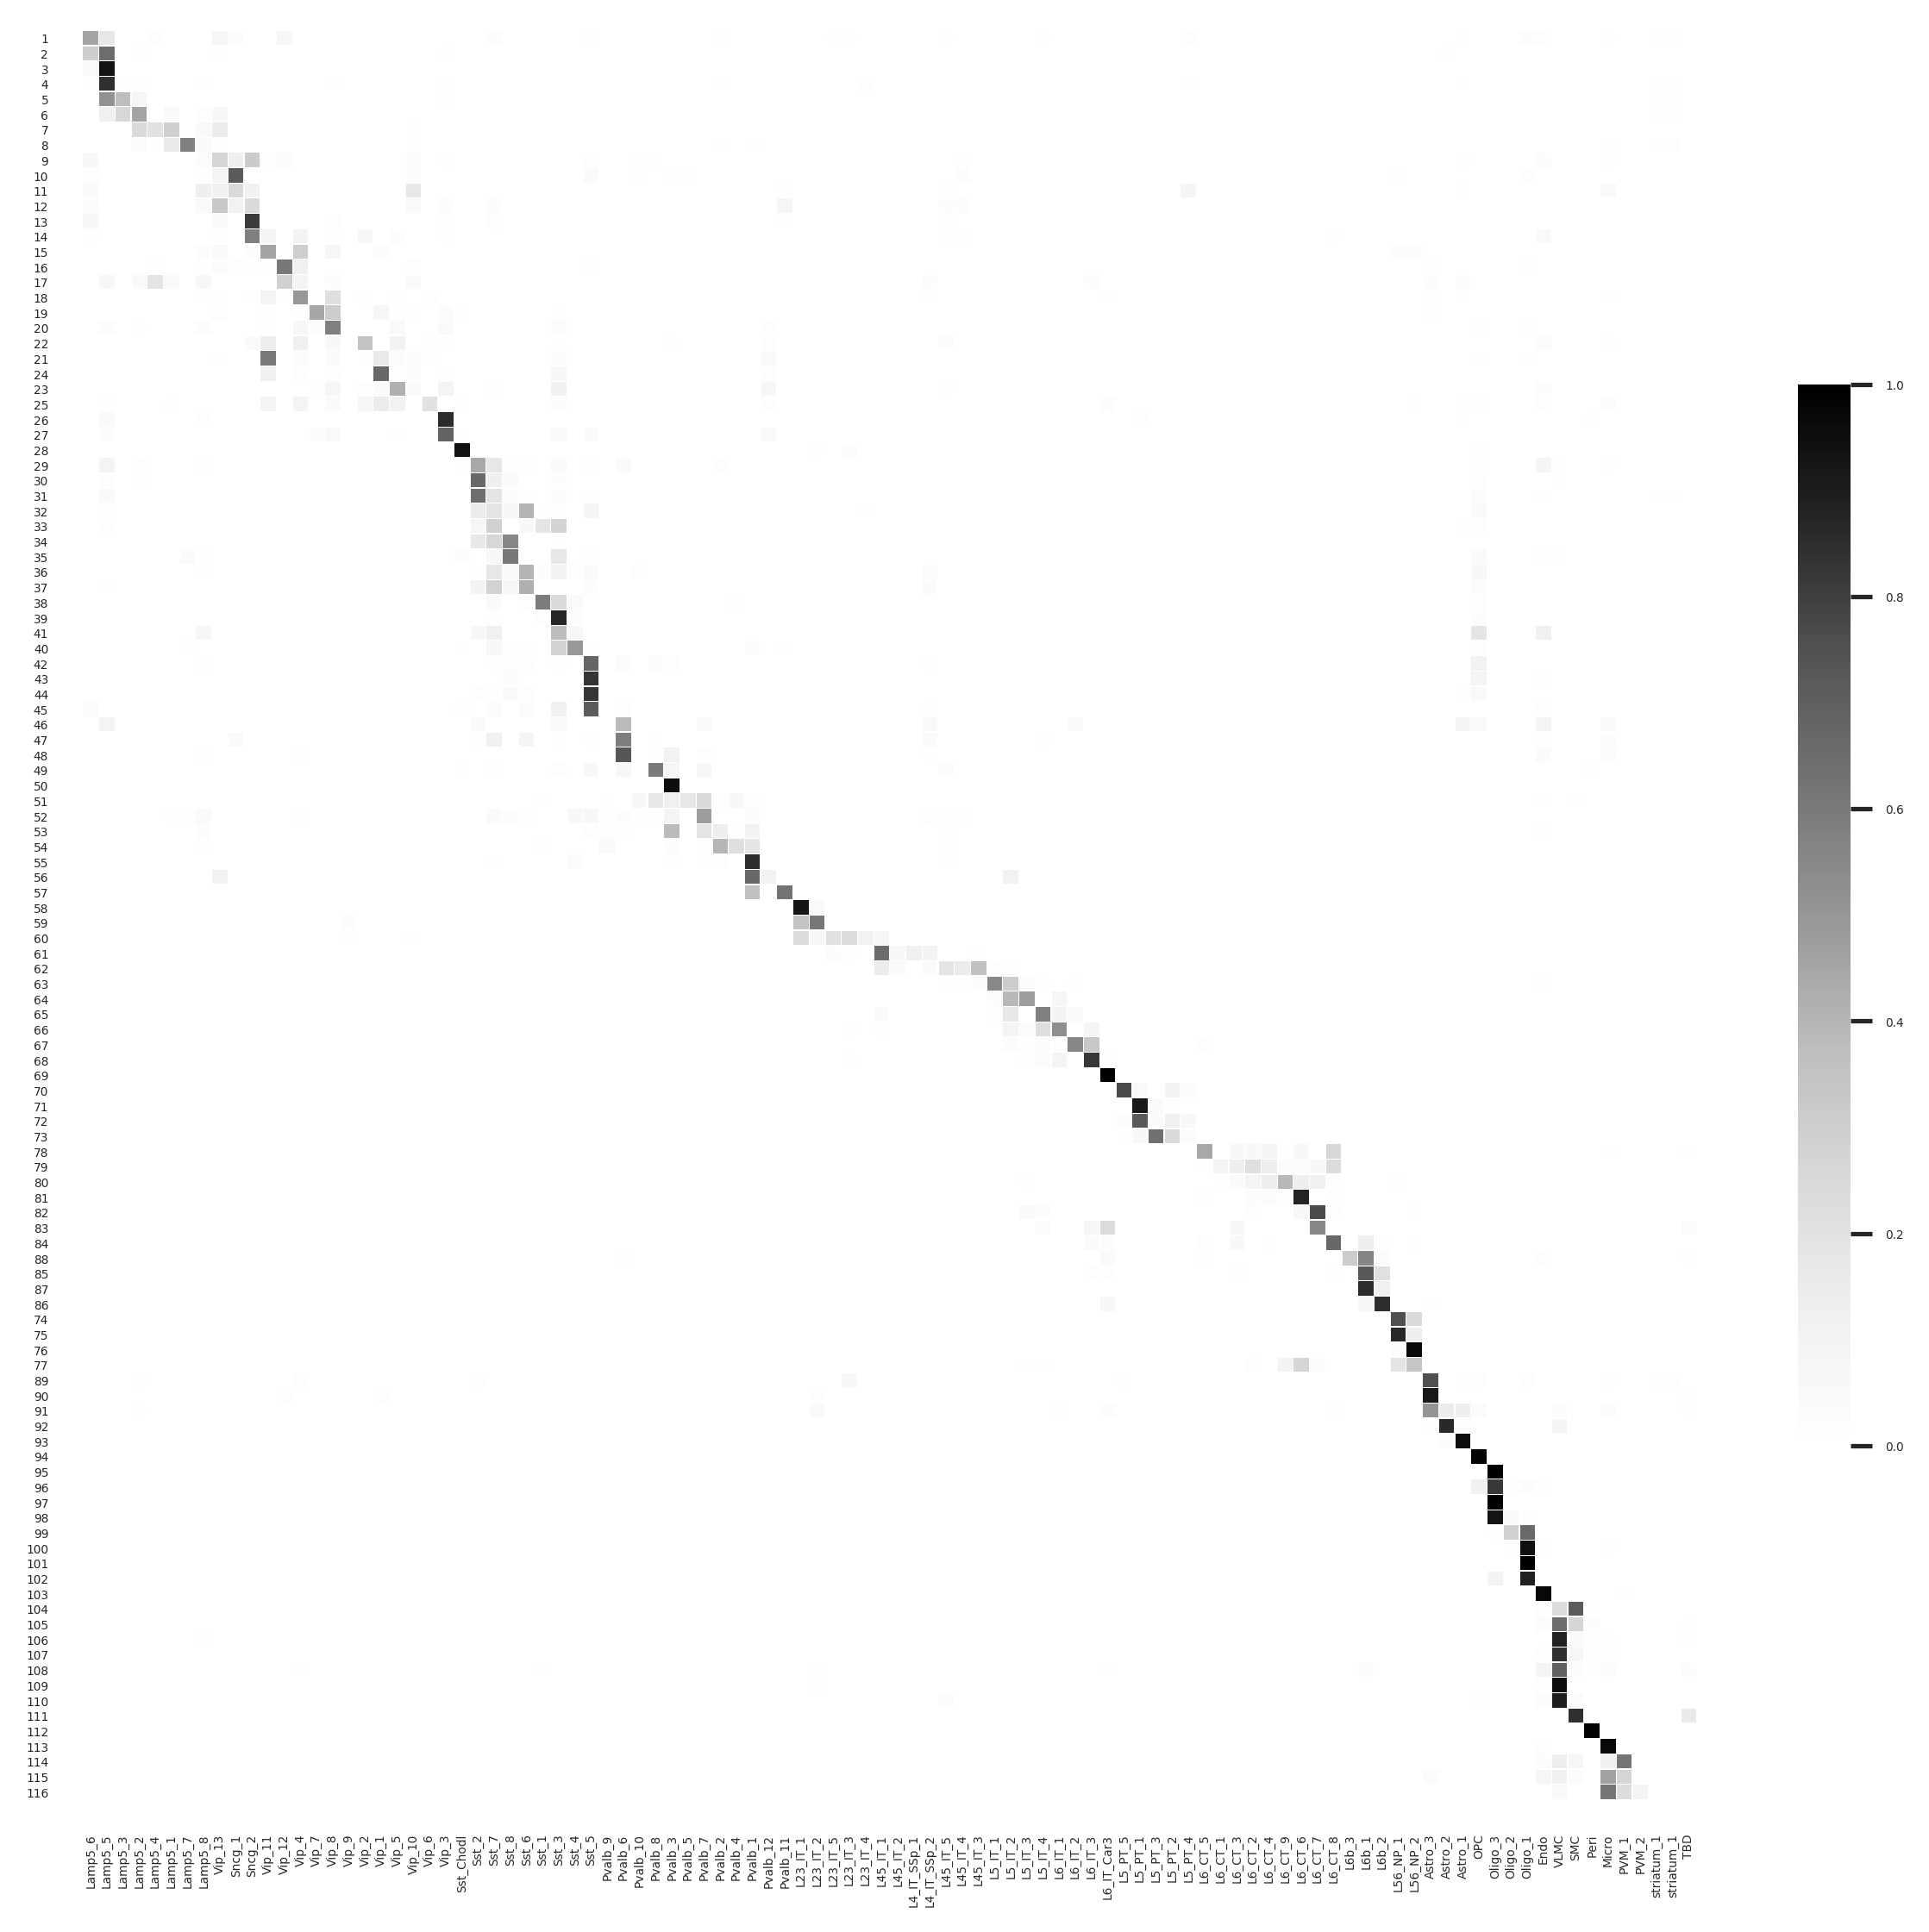

In [988]:
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)
sns.heatmap(fractions_sorted,cmap='Greys',vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
#plt.title('Compare merfish & joint clusters: MGE derived cells')
plt.ylabel("")
plt.xlabel("") 
#plt.yticks([])
#plt.axis('equal') 
plt.show()

In [989]:
fig1.savefig('/n/home04/mengzhang/home/M1_clustering/0408/CompareSeq_cmap2.png',dpi = 600)